### Quick Readme

QAOA approximates the ground state solutions to the 1D Quantum Ising model (analogous to 2D Classical ising model). QAOA tries to choose the solution which maximises the constraint function C(z) = $\Sigma(C_i(z))$. In our case, we need to minimise our cost function and therefore we would be maximising the negative of the cost function.

We strive to minimise $H = |(N_i\vec{s_i})^2|$ 

$H = \Sigma(N_i^2 s_i^2) + N_iN_js_is_j$

Where the first term is a constant and the second term is a quantum ising model (but not only with nearest neighbour interaction).


At low temperatures, the 1D quantum ising model solutions correspond to domains of positive and negative spins. 

### Code

In [459]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import optimization
# import basic plot tools
from qiskit.visualization import plot_histogram

# import algorithms from Qiskit Aqua
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators.primitive_ops import PauliOp

from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.operators.expectations import PauliExpectation
from qiskit.aqua.operators.state_fns import StateFn,CircuitStateFn
from qiskit.aqua.operators.primitive_ops import CircuitOp
from qiskit.aqua.operators.converters import CircuitSampler
from qiskit.aqua.operators import X, Y, Z, I,OperatorBase

from qiskit.compiler import transpile
from qiskit.quantum_info.operators import pauli
from qiskit.quantum_info import Operator

#from qiskit.extensions
from qiskit.extensions import unitary
from qiskit.extensions import HamiltonianGate

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

#from scipy
from scipy.optimize import minimize


#timing
import time

In [472]:
#Prerequisite Functions

#Convert number set to J
def generate_J(inp_set):
    
    """
    inp_set = set of numbers to be partitioned (1D array)
    returns:
        J matrix 
    """
    n = inp_set.size
    J = np.zeros((n,n))
    
    for i in range(0,n):
        for j in range(0,n):
            J[i,j] = inp_set[i]*inp_set[j]

    #normalize                
    J = J/np.sum(np.sum(J)) 
    return J

#Define Ising Hamiltonian
def Ising_Hamiltonian(J):
    """ 
        J : Coupling coefficient matrix (assumes input is an nxn matrix)
        n : no of particles
    """    
    no_of_qbits = J.shape[0]
    
    #initialize H_ising as II...III
    I_n = PauliOp(pauli.Pauli(label='I'*no_of_qbits)) 
    H_ising = I_n
  
    for i in range(0,no_of_qbits):
        for j in range(i,no_of_qbits):
            if i!=j:
                # construct ZiZj
                Z_i     = pauli.Pauli.pauli_single(no_of_qbits,i,"Z")
                Z_j     = pauli.Pauli.pauli_single(no_of_qbits,j,"Z")
                ZiZj    = Z_i*Z_j
                
                # convert them to PauliOp objects
                ZiZj    = PauliOp(ZiZj)
                
                # append to H_ising
                H_ising = H_ising + J[i,j]*ZiZj 
    
    #remove the initial Identity string
    H_ising = H_ising - I_n 
    return H_ising


#H_d
def H_d(no_of_qbits):
    """
    Generates the so-called drive Hamiltonian     
    
    """
    #declare Identity 
    
    #initialize H_d as II...III
    I_n = PauliOp(pauli.Pauli(label='I'*no_of_qbits))
    H_d = I_n
    
    
    for i in range(0,no_of_qbits):
        X_i = pauli.Pauli.pauli_single(no_of_qbits,i,"X")
        H_d = H_d + PauliOp(X_i)

    #remove the initial Identity string
    H_d = H_d - I_n
    return H_d 
            


#define U_j(H,t)
def U_t(H,t):
    """
    Returns a unitary evolution operator for a given input Hamiltonian H and time t
    
    """
    U_t = HamiltonianGate(data=H,time=t).to_matrix()
    return U_t


In [483]:
### Modules for the algorithm

# Unitary operation for U_beta, U_gamma
def U_op(circuit, beta,gamma, H_main,H_drive,qbit_arr):
    
        #generate unitary evolution given values of beta,gamma
        U_t_main  = U_t(H_main ,gamma)
        U_t_drive = U_t(H_drive,beta)
        circuit.unitary(U_t_main,qbit_arr)
        circuit.unitary(U_t_drive,qbit_arr)
        circuit.barrier()


# Calculate Expectation Value
def exp_value_F(psi,F_op,backend,shots=1024):
    """
      Calcultes <psi | F_op | psi>
  
    """
    q_instance = QuantumInstance(backend, shots=shots)
    
    # define the state to sample
    measurable_expression = state_fns.StateFn(F_op, is_measurement=True).compose(psi) #F_op composed of psi vector

    # convert to expectation value
    expectation = PauliExpectation().convert(measurable_expression)  

    # get state sampler 
    sampler = CircuitSampler(q_instance).convert(expectation) 
    return sampler.eval().real


### Function to generate |psi(gamma,beta)> = U(beta,gamma)|+++..+>
def psi_ket_beta_gamma(beta_gamma_arr,inp_set,p,H_main,H_drive,J,no_of_qbits):
    
    #unpack beta,gamma
    beta = beta_gamma_arr[:p]
    gamma = beta_gamma_arr[p:]

    # initial state preparation  |++++...++>
    psi_qc = QuantumCircuit(no_of_qbits)
    for i in range(0,no_of_qbits):
        psi_qc.h(i)                   
    
    # preparing trial state |s> using U(beta,gamma)
    qbit_arr = list(np.arange(0,no_of_qbits,1))
    for i in range(0,p):
        U_op(psi_qc, beta[i], gamma[i], H_main, H_drive, qbit_arr)

    return psi_qc

### Objective function
def QAOA_Obj(beta_gamma_arr,inp_set,p,H_main,H_drive,J,no_of_qbits):
    """
    Calculates the objective function to be minimised which in this case is the 
    expectation value <psi(beta,gamma) | F | psi(beta,gamma)>
    
    Note: I/p beta_gamma_arr : Array containing separate beta and gamma arrays
    
    """
    # Get |psi(gamma,beta)> 
    psi_qc = psi_ket_beta_gamma(beta_gamma_arr,inp_set,p,H_main,H_drive,J,no_of_qbits)
    
    # convert to state function
    psi_ket = CircuitStateFn(psi_qc)
        
    # Calculate expectation value of C(z) (Hmain in this case)
    backend           = Aer.get_backend("qasm_simulator") #declare backend
    exp_value = exp_value_F(psi_ket,H_main,backend)    
    
    return exp_value

In [484]:
## Algorithm
def QAOA_v1(inp_set,p):
    """ 
    QAOA algorithm
    Note: Beta,gamma have to be arrays with size =p
    
    """
    #initializations
    no_of_qbits = np.array(inp_set).size
    J           = generate_J(inp_set)
    H_main      = Ising_Hamiltonian(J)
    H_drive     = H_d(no_of_qbits) 
    t_step      = 1/p
    alpha       = 0.1  #degree of accuracy
    
    # sample beta and gamma vals
    beta_vals = np.random.choice(np.arange(0,np.pi,np.pi/10), p)
    gamma_vals = np.random.choice(np.arange(0,np.pi,np.pi/10), p)
    beta_gamma_arr = np.array([beta_vals,gamma_vals]) #pack 
    
    #print(beta_vals,gamma_vals)
    #res = minimize(QAOA_Obj, x0=beta_gamma_arr, args=(inp_set,p,H_main,H_drive,J,no_of_qbits))

    # run scipy minimise on the QAOA obj fn
    res = minimize(QAOA_Obj, x0=beta_gamma_arr, args=(inp_set,p,H_main,H_drive,J,no_of_qbits),method='powell')

    #adam optimiser
    #obj_f= lambda beta,gamma: QAOA_Obj([beta,gamma],inp_set,p,H_main,H_drive,J,no_of_qbits)
    #adam = ADAM()
    #res = adam.optimize(num_vars=2,objective_function=obj_f)
    
    return res    

### Running on a test set

In [531]:
## Test
inp_set = np.array([1, 4, 5, 8])
H_main      = Ising_Hamiltonian(J)
no_of_qbits = inp_set.size
H_drive     = H_d(no_of_qbits) 
J           = generate_J(inp_set)



#### p=1

In [ ]:
p = 1
res = QAOA_v1(inp_set,p)


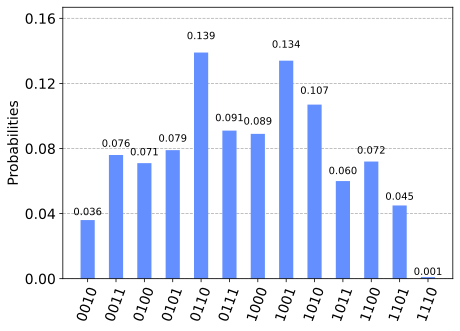

In [530]:
qc1 = psi_ket_beta_gamma(res['x'],inp_set,p,H_main,H_drive,J,no_of_qbits)
qc1.barrier()
qc1.measure_all()
backend = Aer.get_backend("qasm_simulator") #declare backend
counts = execute(qc1, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
plot_histogram(counts)

#### p=2

In [533]:
p = 2
res = QAOA_v1(inp_set,p)
 

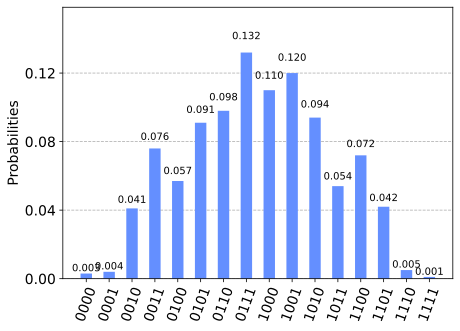

In [534]:
qc1 = psi_ket_beta_gamma(res['x'],inp_set,p,H_main,H_drive,J,no_of_qbits)
qc1.barrier()
qc1.measure_all()
backend = Aer.get_backend("qasm_simulator") #declare backend
counts = execute(qc1, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
plot_histogram(counts)

#### p=3

In [535]:
p = 2
res = QAOA_v1(inp_set,p)
 

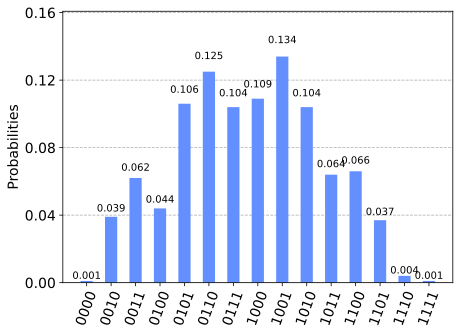

In [536]:
qc1 = psi_ket_beta_gamma(res['x'],inp_set,p,H_main,H_drive,J,no_of_qbits)
qc1.barrier()
qc1.measure_all()
backend = Aer.get_backend("qasm_simulator") #declare backend
counts = execute(qc1, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
plot_histogram(counts)